In [675]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

msft = yf.Ticker("C")
print(msft)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


yfinance.Ticker object <C>


In [676]:
msft.info

{'address1': '388 Greenwich Street',
 'city': 'New York',
 'state': 'NY',
 'zip': '10013',
 'country': 'United States',
 'phone': '212 559 1000',
 'website': 'https://www.citigroup.com',
 'industry': 'Banks - Diversified',
 'industryKey': 'banks-diversified',
 'industryDisp': 'Banks - Diversified',
 'sector': 'Financial Services',
 'sectorKey': 'financial-services',
 'sectorDisp': 'Financial Services',
 'longBusinessSummary': 'Citigroup Inc., a diversified financial service holding company, provides various financial product and services to consumers, corporations, governments, and institutions worldwide. It operates through five segments: Services, Markets, Banking, U.S. Personal Banking, and Wealth. The Services segment includes Treasury and Trade Solutions, which provides cash management, trade, and working capital solutions to multinational corporations, financial institutions, and public sector organizations; and Securities Services, such as cross-border support for clients, local

In [677]:
df = msft.history(period="5y")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-12 00:00:00-04:00,59.630724,59.738553,59.373590,59.531185,15355700,0.0,0.0
2019-07-15 00:00:00-04:00,59.498015,59.846392,58.129386,59.481422,23365800,0.0,0.0
2019-07-16 00:00:00-04:00,59.473129,59.721973,58.967151,59.157932,16516600,0.0,0.0
2019-07-17 00:00:00-04:00,59.050098,59.307232,58.577299,58.743191,12278200,0.0,0.0
2019-07-18 00:00:00-04:00,58.510947,59.639029,58.461181,59.547787,13407400,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-08 00:00:00-04:00,64.300003,64.870003,64.220001,64.739998,10349000,0.0,0.0
2024-07-09 00:00:00-04:00,64.800003,66.760002,64.739998,66.550003,16904300,0.0,0.0
2024-07-10 00:00:00-04:00,66.260002,66.989998,66.220001,66.980003,9817100,0.0,0.0


In [678]:
df = df[['Close']]
df

,Close
Date,
2019-07-12 00:00:00-04:00,59.531185
2019-07-15 00:00:00-04:00,59.481422
2019-07-16 00:00:00-04:00,59.157932
2019-07-17 00:00:00-04:00,58.743191
2019-07-18 00:00:00-04:00,59.547787
...,...
2024-07-08 00:00:00-04:00,64.739998
2024-07-09 00:00:00-04:00,66.550003
2024-07-10 00:00:00-04:00,66.980003


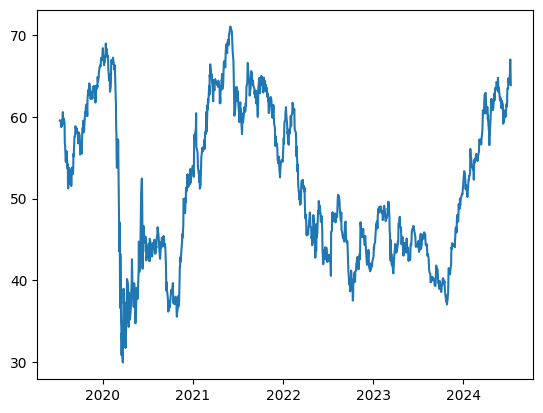

In [679]:
plt.plot(df.index, df['Close'])

In [680]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)


    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2019-07-23 00:00:00-04:00,59.713665,58.983730,58.826138,59.547787,58.743191,59.157932,59.481422,59.531185
2019-07-24 00:00:00-04:00,60.559753,59.713665,58.983730,58.826138,59.547787,58.743191,59.157932,59.481422
2019-07-25 00:00:00-04:00,59.216000,60.559753,59.713665,58.983730,58.826138,59.547787,58.743191,59.157932
2019-07-26 00:00:00-04:00,59.854691,59.216000,60.559753,59.713665,58.983730,58.826138,59.547787,58.743191
2019-07-29 00:00:00-04:00,59.522911,59.854691,59.216000,60.559753,59.713665,58.983730,58.826138,59.547787
...,...,...,...,...,...,...,...,...
2024-07-08 00:00:00-04:00,64.739998,64.029999,64.459999,64.680000,63.430000,63.459999,61.549999,61.250000
2024-07-09 00:00:00-04:00,66.550003,64.739998,64.029999,64.459999,64.680000,63.430000,63.459999,61.549999
2024-07-10 00:00:00-04:00,66.980003,66.550003,64.739998,64.029999,64.459999,64.680000,63.430000,63.459999


In [681]:
shifted_df_np = shifted_df.to_numpy()
shifted_df_np

array([[59.71366501, 58.98373032, 58.82613754, ..., 59.15793228,
        59.48142242, 59.53118515],
       [60.55975342, 59.71366501, 58.98373032, ..., 58.74319077,
        59.15793228, 59.48142242],
       [59.2159996 , 60.55975342, 59.71366501, ..., 59.54778671,
        58.74319077, 59.15793228],
       ...,
       [66.98000336, 66.55000305, 64.73999786, ..., 64.68000031,
        63.43000031, 63.45999908],
       [65.70999908, 66.98000336, 66.55000305, ..., 64.45999908,
        64.68000031, 63.43000031],
       [63.84329987, 65.70999908, 66.98000336, ..., 64.02999878,
        64.45999908, 64.68000031]])

In [682]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

array([[0.4491022 , 0.41352255, 0.40584091, ..., 0.42201378, 0.43778186,
        0.44020747],
       [0.49034359, 0.4491022 , 0.41352255, ..., 0.40179779, 0.42201378,
        0.43778186],
       [0.42484419, 0.49034359, 0.4491022 , ..., 0.44101669, 0.40179779,
        0.42201378],
       ...,
       [0.80328966, 0.7823299 , 0.69410374, ..., 0.69117924, 0.63024974,
        0.63171199],
       [0.74138508, 0.80328966, 0.7823299 , ..., 0.68045559, 0.69117924,
        0.63024974],
       [0.65039545, 0.74138508, 0.80328966, ..., 0.65949583, 0.68045559,
        0.69117924]])

In [683]:
X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

X.shape, y.shape
print(X)

[[0.41352255 0.40584091 0.44101669 ... 0.42201378 0.43778186 0.44020747]
 [0.4491022  0.41352255 0.40584091 ... 0.40179779 0.42201378 0.43778186]
 [0.49034359 0.4491022  0.41352255 ... 0.44101669 0.40179779 0.42201378]
 ...
 [0.7823299  0.69410374 0.65949583 ... 0.69117924 0.63024974 0.63171199]
 [0.80328966 0.7823299  0.69410374 ... 0.68045559 0.69117924 0.63024974]
 [0.74138508 0.80328966 0.7823299  ... 0.65949583 0.68045559 0.69117924]]


In [684]:
X = dc(np.flip(X, axis=1))
X
split_index = int(len(X) * .95)
split_index

1189

In [685]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1189, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1189, 1]),
 torch.Size([63, 1]))

In [686]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset

In [687]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [688]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 16, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [689]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print() 
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [690]:
learning_rate = 0.002
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.009
***************************************************

Epoch: 2

Val Loss: 0.006
***************************************************

Epoch: 3

Val Loss: 0.006
***************************************************

Epoch: 4

Val Loss: 0.005
***************************************************

Epoch: 5

Val Loss: 0.010
***************************************************

Epoch: 6

Val Loss: 0.005
***************************************************

Epoch: 7

Val Loss: 0.009
***************************************************

Epoch: 8

Val Loss: 0.004
***************************************************

Epoch: 9

Val Loss: 0.003
***************************************************

Epoch: 10

Val Loss: 0.003
***************************************************

Epoch: 11

Val Loss: 0.003
***************************************************

Epoch: 12

Val Loss: 0.003
***************************************************

Epoch: 13

Val Loss: 0.003
**********************

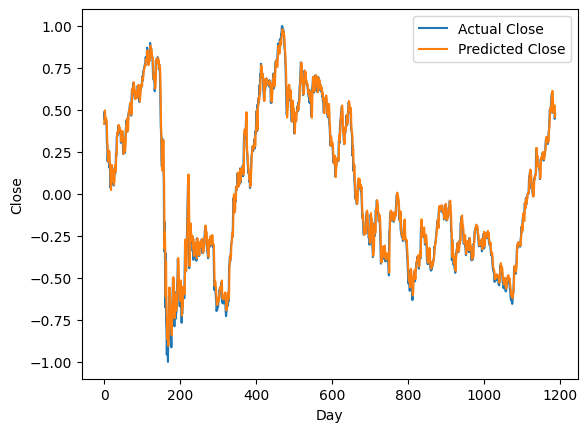

In [691]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')

plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [692]:
print(y_train.shape)
print(predicted.shape)
train_predictions = predicted.flatten()
print(train_predictions.shape)

torch.Size([1189, 1])
(1189, 1)
(1189,)


In [693]:

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([59.04563962, 59.77168533, 60.69991516, ..., 61.30523796,
       61.28160574, 59.86955801])

In [694]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([59.71366497, 60.5597537 , 59.21599985, ..., 61.12896724,
       59.66171285, 60.18714882])

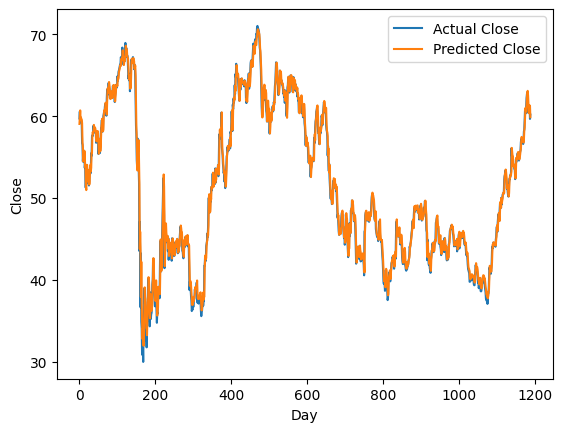

In [695]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [696]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([60.08277747, 59.30664322, 58.10336571, 56.48867714, 57.45967815,
       57.97949038, 58.78628562, 60.54527123, 62.32888871, 62.3319372 ,
       61.50844497, 62.07365072, 61.89277852, 60.96150204, 60.80106683,
       61.03809092, 61.58721536, 62.84029405, 62.32382624, 62.75736973,
       63.37308406, 63.6497532 , 63.53033382, 63.63087041, 64.21861029,
       64.25180863, 64.14236135, 63.29916704, 64.50260045, 64.04707554,
       63.14187203, 63.46790397, 62.61653022, 62.02311156, 61.91200369,
       62.3088846 , 62.06679436, 61.16938144, 61.68678226, 62.03697712,
       61.93280753, 61.55326377, 59.32662287, 59.7596913 , 60.28678175,
       59.54854636, 60.04565754, 60.87431252, 60.85202908, 60.17315976,
       61.2712509 , 61.76633648, 61.47130792, 61.61774796, 63.36069812,
       63.68751388, 64.67518804, 64.64504309, 64.16112063, 64.64460042,
       66.29276002, 66.98620902, 65.97541133])

In [697]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([59.16601953, 58.05566778, 56.52892687, 57.66902188, 57.81773024,
       58.63066893, 60.42508331, 62.1302685 , 61.93199191, 61.25784635,
       62.12035388, 61.72379702, 60.80181153, 60.82163588, 61.01000275,
       61.52000062, 62.81000113, 62.00000027, 62.7499998 , 63.32000022,
       63.52999877, 63.400002  , 63.5900001 , 64.23999741, 64.13999886,
       64.06999975, 63.16000034, 64.7399975 , 63.81999909, 63.0200009 ,
       63.58000232, 62.45000047, 62.00999804, 61.92999994, 62.31000103,
       61.91999849, 61.0299983 , 61.77000005, 61.93999893, 61.77999905,
       61.42999984, 59.13999914, 60.00999828, 60.22999949, 59.33000214,
       60.06000122, 60.77999886, 60.61999898, 59.9900015 , 61.34000029,
       61.58000195, 61.24999951, 61.54999884, 63.45999966, 63.43000022,
       64.67999984, 64.45999863, 64.02999886, 64.7399975 , 66.55000345,
       66.98000321, 65.70999947, 63.84329993])

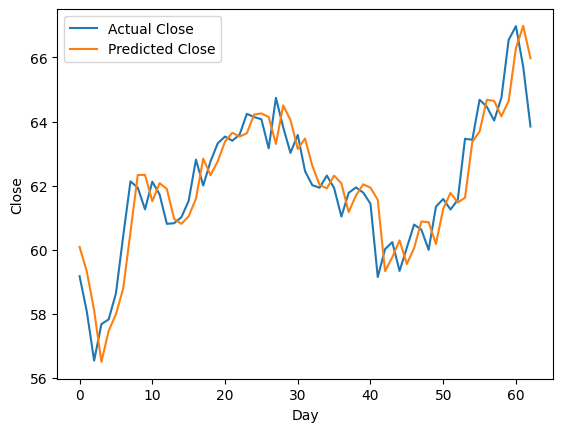

In [698]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [699]:
test_predictions

array([60.08277747, 59.30664322, 58.10336571, 56.48867714, 57.45967815,
       57.97949038, 58.78628562, 60.54527123, 62.32888871, 62.3319372 ,
       61.50844497, 62.07365072, 61.89277852, 60.96150204, 60.80106683,
       61.03809092, 61.58721536, 62.84029405, 62.32382624, 62.75736973,
       63.37308406, 63.6497532 , 63.53033382, 63.63087041, 64.21861029,
       64.25180863, 64.14236135, 63.29916704, 64.50260045, 64.04707554,
       63.14187203, 63.46790397, 62.61653022, 62.02311156, 61.91200369,
       62.3088846 , 62.06679436, 61.16938144, 61.68678226, 62.03697712,
       61.93280753, 61.55326377, 59.32662287, 59.7596913 , 60.28678175,
       59.54854636, 60.04565754, 60.87431252, 60.85202908, 60.17315976,
       61.2712509 , 61.76633648, 61.47130792, 61.61774796, 63.36069812,
       63.68751388, 64.67518804, 64.64504309, 64.16112063, 64.64460042,
       66.29276002, 66.98620902, 65.97541133])

In [700]:

test_dates = df.index[-len(new_y_test):]

# Create dataframe with dates, actual and predicted values
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': new_y_test,
    'Predicted': test_predictions
})
print("Test Results:")
print(test_results_df)



Test Results:
                        Date     Actual  Predicted
0  2024-04-12 00:00:00-04:00  59.166020  60.082777
1  2024-04-15 00:00:00-04:00  58.055668  59.306643
2  2024-04-16 00:00:00-04:00  56.528927  58.103366
3  2024-04-17 00:00:00-04:00  57.669022  56.488677
4  2024-04-18 00:00:00-04:00  57.817730  57.459678
..                       ...        ...        ...
58 2024-07-08 00:00:00-04:00  64.739998  64.161121
59 2024-07-09 00:00:00-04:00  66.550003  64.644600
60 2024-07-10 00:00:00-04:00  66.980003  66.292760
61 2024-07-11 00:00:00-04:00  65.709999  66.986209
62 2024-07-12 00:00:00-04:00  63.843300  65.975411

[63 rows x 3 columns]


In [701]:
def predict_future_dates(model, last_known_data, scaler, num_predictions):
    model.eval()
    predictions = []
    data = last_known_data
    for _ in range(num_predictions):
        input_data = torch.tensor(data.reshape(
            1, lookback, 1)).float().to(device)
        with torch.no_grad():
            pred = model(input_data).cpu().numpy().flatten()
        predictions.append(pred[0])
        data = np.append(data[1:], pred)
    predictions = np.array(predictions).reshape(-1, 1)
    dummies = np.zeros((predictions.shape[0], lookback + 1))
    dummies[:, 0] = predictions.flatten()
    predictions = scaler.inverse_transform(dummies)[:, 0]
    return predictions


# Predict future dates
num_future_predictions = 2
last_known_data = X_test[-1].cpu().numpy()
future_predictions = predict_future_dates(
    model, last_known_data, scaler, num_future_predictions)

# Create future dates
last_date = test_results_df['Date'].iloc[-1]
future_dates = pd.date_range(
    start=last_date, periods=num_future_predictions)

print(future_dates)
future_predictions

DatetimeIndex(['2024-07-12 00:00:00-04:00', '2024-07-13 00:00:00-04:00'], dtype='datetime64[ns, America/New_York]', freq='D')


array([65.97541255, 65.85981204])

In [702]:
predictions = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted'])
predictions['Percent Change'] = predictions['Predicted'].pct_change()

predictions

,Predicted,Percent Change
2024-07-12 00:00:00-04:00,65.975413,NaN
2024-07-13 00:00:00-04:00,65.859812,-0.001752
